In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
import numpy as np
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from bb_opt.src.bayesian_opt import (
    optimize,
    get_model_bnn,
    train_model_bnn,
    partial_train_model_bnn,
    train,
    bnn_predict
)
from bb_opt.src.utils import get_path, save_pyro_model, load_pyro_model
from gpu_utils.utils import gpu_init
from tqdm import tnrange

gpu_id = gpu_init()
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

Running on GPU 0


In [2]:
def jointplot(predicted, true, title: str=""):
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.detach().cpu().numpy()

    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
        
    ax = sns.jointplot(predicted, true, s=3, alpha=0.5)
    ax.set_axis_labels('Predicted', 'True')
    ax.ax_marg_x.set_title(title)
    return ax

In [3]:
n_train = 100

project = "dna_binding"
dataset = "crx_ref_r1"
batch_size = 1
retrain_every = 1000000
partial_steps = 20

root = "/cluster/nhunt/github/bb_opt/"
data_dir = get_path(root, "data", project, dataset)
inputs = np.load(get_path(data_dir, "inputs.npy"))
labels = np.load(get_path(data_dir, "labels.npy"))
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=n_train, random_state=521)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, train_size=0.9, random_state=521)

top_k_percent = 1

/cluster/nhunt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
train_label_mean = train_labels.mean()
train_label_std = train_labels.std()

train_labels = (train_labels - train_label_mean) / train_label_std
val_labels = (val_labels - train_label_mean) / train_label_std
test_labels = (test_labels - train_label_mean) / train_label_std

In [5]:
n_samples = 10
prior_mean = 0
prior_std = 1

bnn_model, guide = get_model_bnn(inputs.shape[1], batch_size, prior_mean, prior_std, device=device)
optimizer = pyro.optim.Adam({})

pyro.clear_param_store()

svi = pyro.infer.SVI(bnn_model, guide, optimizer, pyro.infer.Trace_ELBO(n_samples))

to_torch = lambda array: torch.tensor(array, dtype=torch.float32, device=device)
train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels = list(map(to_torch, [train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels]))

In [6]:
train_losses = []
val_losses = []

train_corrs = []
val_corrs = []

In [40]:
model_path = "crx_100_starter"

progress = tnrange(1000)
for _ in progress:
    train_losses += train(svi, 5, train_inputs, train_labels, verbose=False)

    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    train_corrs.append(kendalltau(preds, train_labels)[0])

#     if n_inputs == 1:
#         mses.append((preds - train_labels.item()) ** 2)

    preds = bnn_predict(guide, val_inputs, n_samples=50).mean(axis=0)
    val_corr = kendalltau(preds, val_labels)[0]

    if val_corr > max(val_corrs, default=-float("inf")):
        save_pyro_model(model_path, optimizer)

    val_corrs.append(val_corr)
    progress.set_description(f"Corr: {val_corr:.3f}")


#     _, sorted_idx = train_labels.sort(descending=True)
#     n_10_percent = int(len(train_labels) * .1)

#     preds = bnn_predict(guide, train_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
#     best_train_corrs.append(kendalltau(preds, train_labels[sorted_idx][:n_10_percent])[0])

#     _, sorted_idx = test_labels.sort(descending=True)
#     n_10_percent = int(len(test_labels) * .1)

#     preds = bnn_predict(guide, test_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
#     best_test_corrs.append(kendalltau(preds, test_labels[sorted_idx][:n_10_percent])[0])

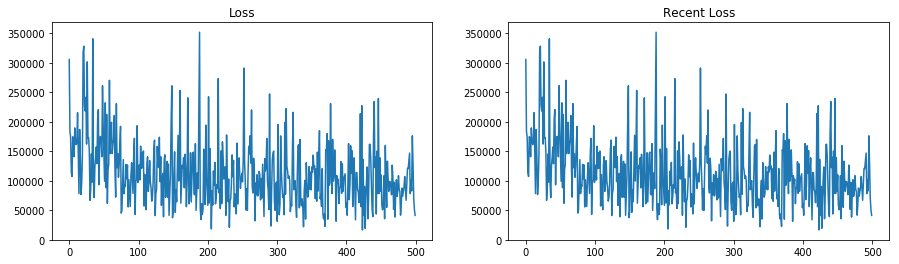

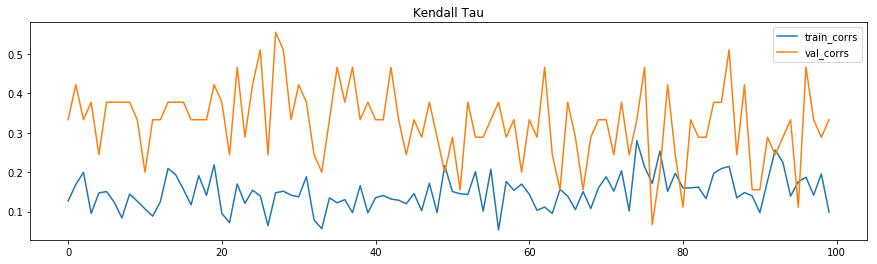

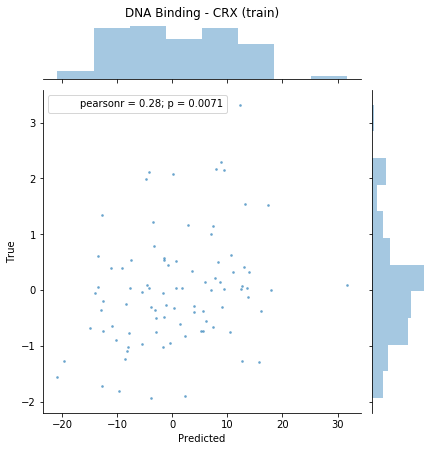

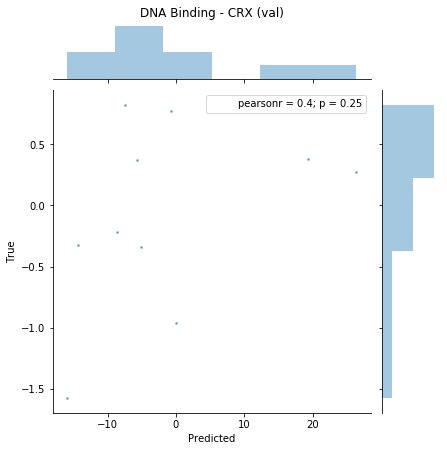

In [11]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(train_losses)
plt.title("Loss")

plt.subplot(122)
plt.plot(train_losses[-3000:])
plt.title("Recent Loss")

plt.figure(figsize=(15, 4))

# plt.subplot(121)
# plt.plot(mses)
# plt.title("MSE")

# plt.subplot(122)
plt.plot(train_corrs, label="train_corrs")
plt.plot(val_corrs, label="val_corrs")
plt.legend()
plt.title("Kendall Tau");
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

title = "DNA Binding - CRX"
train_title = title + " (train)"
val_title = title + " (val)"

if n_train > 1:
    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    jointplot(preds, train_labels, train_title)

preds = bnn_predict(guide, val_inputs, n_samples=50).mean(axis=0)
jointplot(preds, val_labels, val_title);

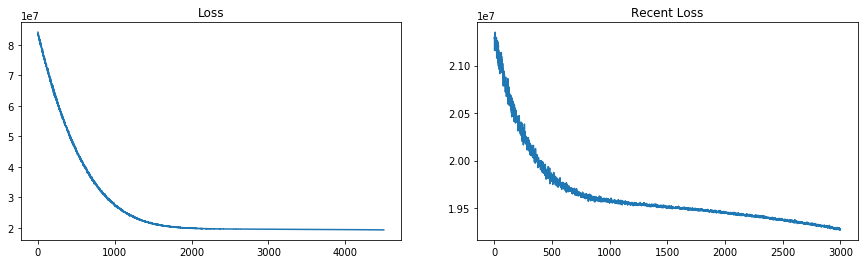

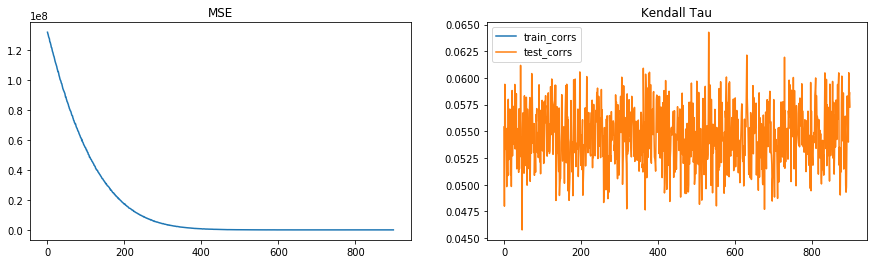

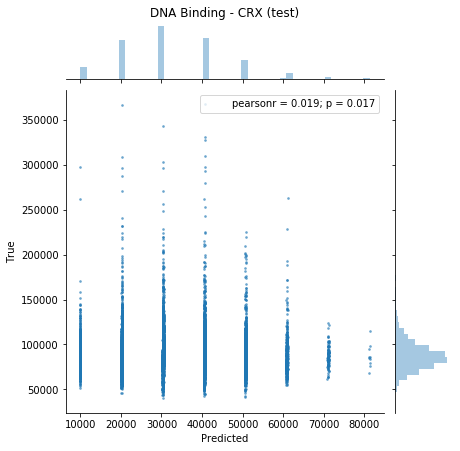

In [29]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(losses)
plt.title("Loss")

plt.subplot(122)
plt.plot(losses[-3000:])
plt.title("Recent Loss")

plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(mses)
plt.title("MSE")

plt.subplot(122)
plt.plot(train_corrs, label="train_corrs")
plt.plot(test_corrs, label="test_corrs")
plt.legend()
plt.title("Kendall Tau");
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

title = "DNA Binding - CRX"
train_title = title + " (train)"
test_title = title + " (test)"

if n_inputs > 1:
    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    jointplot([preds], train_labels, train_title)

preds = bnn_predict(guide, test_inputs, n_samples=50).mean(axis=0)
jointplot(preds, test_labels, test_title);

In [30]:
save_pyro_model(model_path, optimizer)

In [23]:
from bb_opt.src.hsic import dimwise_mixrq_kernels, dimwise_mixrbf_kernels, total_hsic

In [15]:
n_preds = 50
with torch.no_grad():
    preds = [torch.unsqueeze(guide()(train_inputs).squeeze(), 0) for _ in range(n_preds)]
preds = torch.cat(preds)

In [20]:
preds.shape

torch.Size([50, 90])

In [21]:
preds.max(), preds.min()

(tensor(136.8035, device='cuda:0'), tensor(-142.3965, device='cuda:0'))

In [22]:
train_labels.max(), train_labels.min()

(tensor(3.3230, device='cuda:0'), tensor(-1.9331, device='cuda:0'))

In [39]:
k = dimwise_mixrq_kernels(preds)
k.shape, k.max(), k.min()

(torch.Size([50, 50, 90]),
 tensor(1., device='cuda:0'),
 tensor(0.0187, device='cuda:0'))

In [25]:
total_hsic(k)

tensor(0.0200, device='cuda:0')

In [35]:
k = dimwise_mixrbf_kernels(preds.to(torch.float64))
k.shape, k.dtype

torch.Size([1, 50, 50, 90]) torch.Size([7, 1, 1, 1])
torch.Size([7, 50, 50, 90]) torch.Size([7])


(torch.Size([50, 50, 90]), torch.float64)

In [38]:
k.max(), k.min()

(tensor(1.9459, device='cuda:0', dtype=torch.float64),
 tensor(-3.4189, device='cuda:0', dtype=torch.float64))

In [36]:
total_hsic(k)

tensor(229009551886410026088746777735557235013770395563675736323081533310971674624.,
       device='cuda:0', dtype=torch.float64)

In [41]:
from IPython.display import Audio, display


class InvisibleAudio(Audio):
    def _repr_html_(self):
        audio = super()._repr_html_()
        audio = audio.replace('<audio', f'<audio onended="this.parentNode.removeChild(this)"')
        return f'<div style="display:none">{audio}</div>'

In [42]:
from time import time, sleep
from IPython import get_ipython
from IPython.core.magic import register_line_cell_magic
from IPython.display import Audio, display
from IPython.core.display import HTML

from IPython.core import magic_arguments
from IPython.core.magic import line_cell_magic, Magics, magics_class
 
@magics_class
class NotificationMagics(Magics):
    @line_cell_magic
    @magic_arguments.magic_arguments()
    @magic_arguments.argument('--url', '-u',
          help='URL of sound to play
    )
    def notify(self, line, cell=None, url: str='http://www.soundjay.com/button/beep-07.wav'):
        if cell is None:
            ret = self.shell.ex(line)
        else:
            ret = self.shell.ex(cell)

        audio = InvisibleAudio(url=url, autoplay=True)
        display(audio)

        return ret

SyntaxError: EOL while scanning string literal (<ipython-input-42-3690aada117a>, line 15)

In [ ]:
ip = get_ipython()
ip.register_magics(NotificationMagics)

In [ ]:
%notify